### Import Packages

In [51]:
from keras.preprocessing.image import ImageDataGenerator
import os 
from matplotlib import pyplot as pt
import pandas as pd

### Common Parameters

In [74]:
batch_size = 32
image_size = 150
data_img_path = os.path.abspath(os.path.join(os.getcwd(), 'data', 'REFUGE-Training400', 'Training400'))
# 这套青光眼的数据中，用来validation和用来test的数据很可能是同一批数据
# 这套青光眼的数据的另一个问题是，Training的数据和validation的数据都是400个，training的太少了，用来validation的比例又太多了
# validation的答案在data\REFUGE-Validation400-GT\Fovea_locations这个文件中

valid_img_path = os.path.abspath(os.path.join(os.getcwd(), 'data', 'REFUGE-Validation400'))
valid_mask_path = os.path.abspath(os.path.join(os.getcwd(), 'data', 'REFUGE-Validation400-GT'))#validation数据的答案存在这里
valid_dataframe=pd.read_csv(valid_mask_path+"\Fovea_locations.csv")
valid_dataframe['Glaucoma_Label'] = valid_dataframe['Glaucoma_Label'].astype(str)

In [75]:
valid_dataframe

,ID,ImgName,Glaucoma_Label,Fovea_X,Fovea_Y
0,1,V0001.jpg,0,1050.07,858.55
1,2,V0002.jpg,0,1131.07,834.53
2,3,V0003.jpg,0,867.01,838.64
3,4,V0004.jpg,0,1113.65,877.35
4,5,V0005.jpg,0,1138.70,841.77
...,...,...,...,...,...
395,396,V0396.jpg,0,1144.06,835.20
396,397,V0397.jpg,0,1155.05,835.16
397,398,V0398.jpg,0,1130.76,865.07
398,399,V0399.jpg,0,1032.00,999.50


### Image Loader

我当然可以直接使用keras自带的图片生成器，它可以返回文件的类（也就是其所在文件夹的名字）以及这个图片本身的numpy格式（可以直接画成图）

不过为了通用性和可重复使用，最好是能够写一个方程，直接读取单一文件夹/多重文件夹里面的文件名及文件自身

#### 图片可以进行增殖，也可以保持原样

In [37]:
#以下图片产生器可对图片进行扭曲增殖
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [31]:
#以下图片产生器不扭曲图片
datagen_wo_aug = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        fill_mode='nearest')

In [44]:
#以下图片产生器不扭曲图片
valid_dataGen_wo_aug = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        fill_mode='nearest')

In [32]:
train_generator = datagen_wo_aug.flow_from_directory(
        data_img_path,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 400 images belonging to 2 classes.


不幸的是，validation和test数据都是用dataframe储存文件名和标签的，需要用以下方法生成图片：

In [77]:
#train_generator = train_dataGen.flow_from_dataframe()
#如果validation的标签不是以文件夹的形式而是单独的文件，就需要用别的方式读取
#[https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow]
valid_generator = valid_dataGen_wo_aug.flow_from_dataframe(
                                        dataframe = valid_dataframe,
                                        directory = valid_img_path,
                                        x_col="ImgName",
                                        y_col="Glaucoma_Label",
                                        class_mode="binary",
                                        target_size=(128,128),
                                        batch_size=32)

Found 400 validated image filenames belonging to 2 classes.


In [33]:
train_generator.class_indices

{'Glaucoma': 0, 'Non-Glaucoma': 1}

In [34]:
batchX, batchy = train_generator.next()

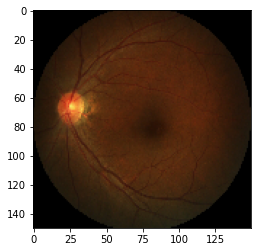

In [35]:
pt.imshow(batchX[0])

In [40]:
batchy[0]

1.0

In [42]:
batchX.shape#这个图片产生器里有32个图

(32, 150, 150, 3)

### 其它的图片产生器

#### m-net那家人的图片产生器是专门为多标签系统制作的，它返回([train_img], [img_mask, img_mask, img_mask, img_mask, img_mask])

#### 其中前面一个[]是图片，后面[]里有5个mask都属于Unet的答案，也即mask

#### 值得注意的是，这个train_loader一次只产生一个图片并返回

只在一种情况下它可以正常工作，就是一次被调用很多次，比如一次调用32次产生32张图片。然而这不可能，它的while 1决定了它会一次性跑完400张图片

与此同时，它里面每一个循环都会替换掉之前的图，最终只返回最后一张图

它还有一种可能性是由fit_generator控制开和关，最终它总是产生前面几张图片

In [ ]:
def train_loader(data_list, data_path, mask_path, input_size):
    while 1:
        for lineIdx, temp_txt in enumerate(data_list):
            train_img = np.asarray(image.load_img(os.path.join(data_path, temp_txt),
                                                  target_size=(input_size, input_size, 3))#这一行似乎只载入1张图片
                                   ).astype('float32')
            img_mask = np.asarray(
                image.load_img(os.path.join(mask_path, temp_txt),
                               target_size=(input_size, input_size, 3))
            ) / 255.0

            train_img = np.reshape(train_img, (1,) + train_img.shape)#如果这个是不断累加新的图片到原本的图片容器中，则返的yield=>
            img_mask = np.reshape(img_mask, (1,) + img_mask.shape)
            yield ([train_img], [img_mask, img_mask, img_mask, img_mask, img_mask])#=>返回的yield会越来越大，第一次为1张图片，第400次为400张图片

In [38]:
import numpy as np

In [ ]:
np.reshape()

In [39]:
(1,)+(150,150,3)#两个turple相加得到一个图片的新shape，这等于说train_loader一次只产生一张图片

(1, 150, 150, 3)